Epoch 1/10


2023-10-20 22:12:06.984482: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


565/565 [==============================] - 2s 3ms/step - loss: 0.7458 - accuracy: 0.7165 - val_loss: 0.3155 - val_accuracy: 0.8770
Epoch 2/10
565/565 [==============================] - 2s 3ms/step - loss: 0.2526 - accuracy: 0.9073 - val_loss: 0.1911 - val_accuracy: 0.9380
Epoch 3/10
565/565 [==============================] - 2s 3ms/step - loss: 0.1738 - accuracy: 0.9375 - val_loss: 0.1913 - val_accuracy: 0.9256
Epoch 4/10
565/565 [==============================] - 1s 3ms/step - loss: 0.1343 - accuracy: 0.9517 - val_loss: 0.1209 - val_accuracy: 0.9581
Epoch 5/10
565/565 [==============================] - 1s 3ms/step - loss: 0.1003 - accuracy: 0.9634 - val_loss: 0.1009 - val_accuracy: 0.9657
Epoch 6/10
565/565 [==============================] - 2s 3ms/step - loss: 0.0848 - accuracy: 0.9699 - val_loss: 0.0875 - val_accuracy: 0.9685
Epoch 7/10
565/565 [==============================] - 2s 3ms/step - loss: 0.0736 - accuracy: 0.9733 - val_loss: 0.1066 - val_accuracy: 0.9643
Epoch 8/10
565/56

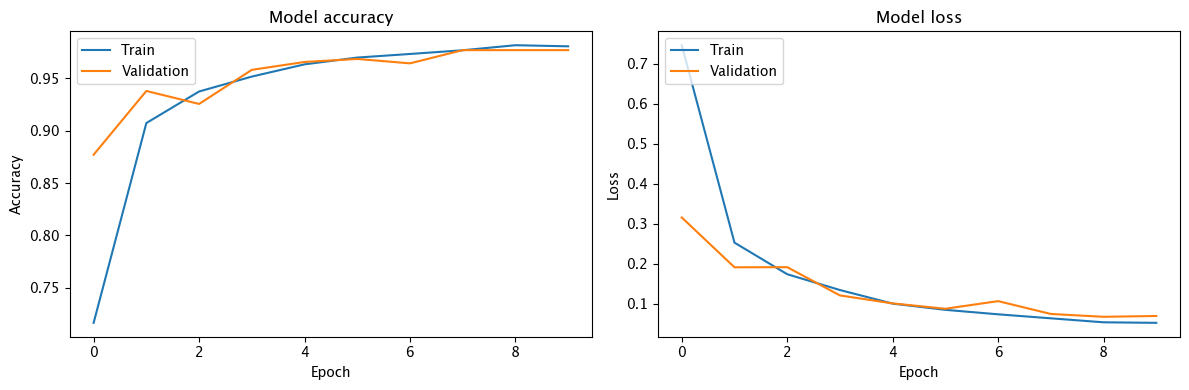

706/706 [==============================] - 0s 573us/step


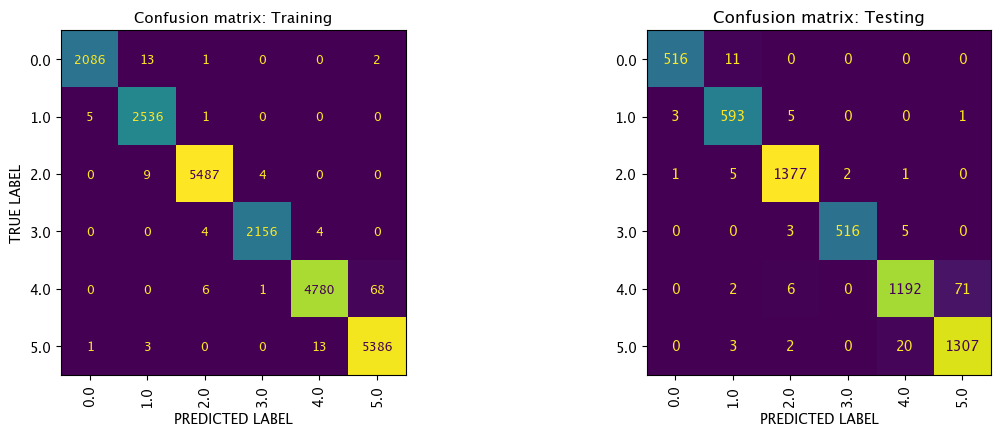

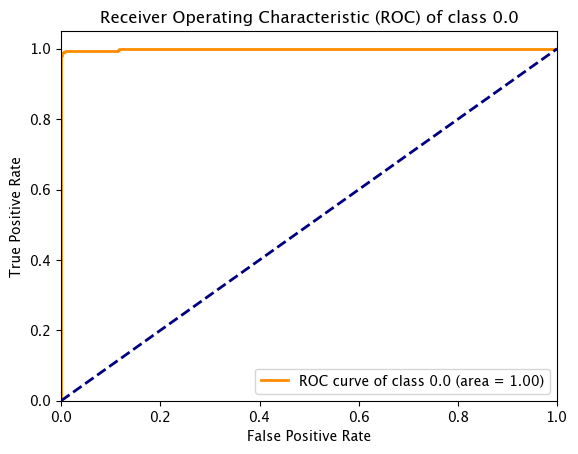

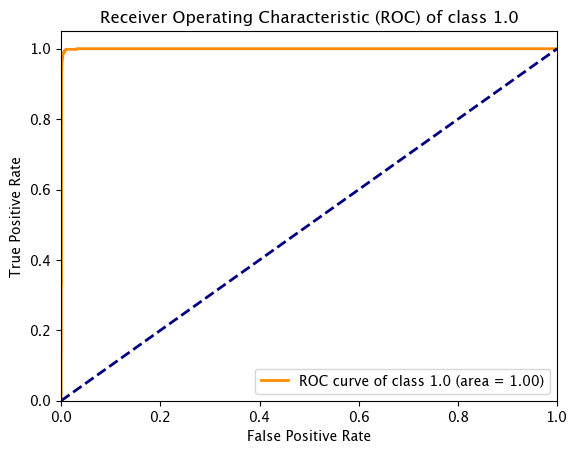

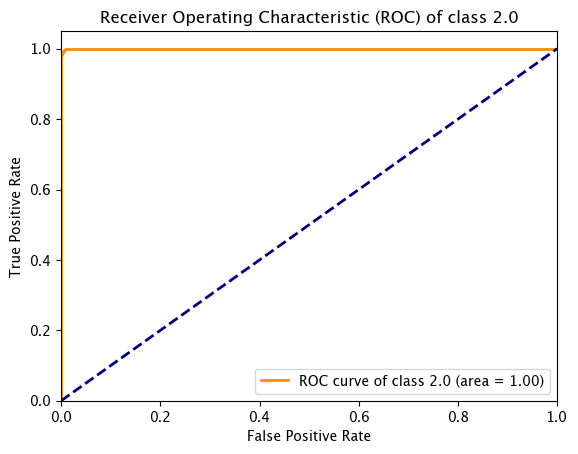

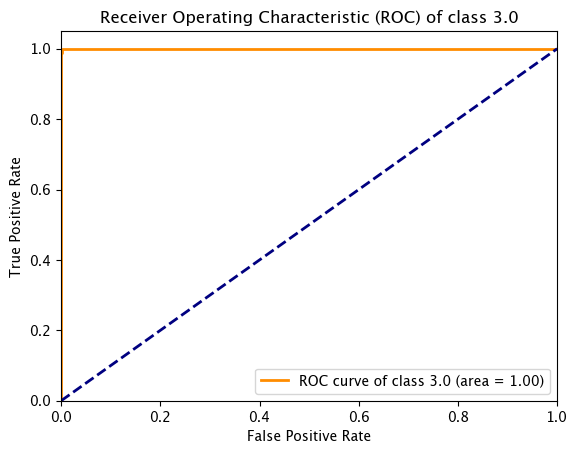

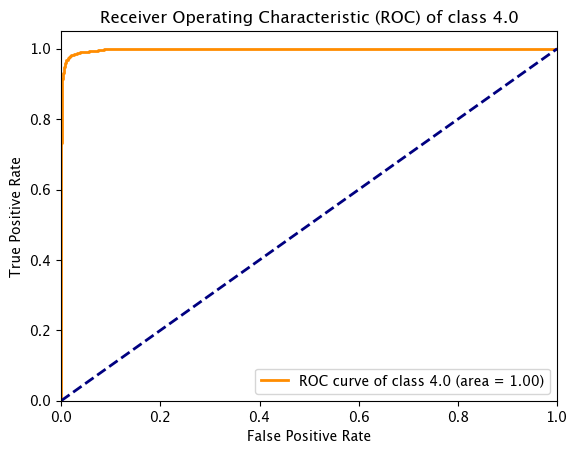

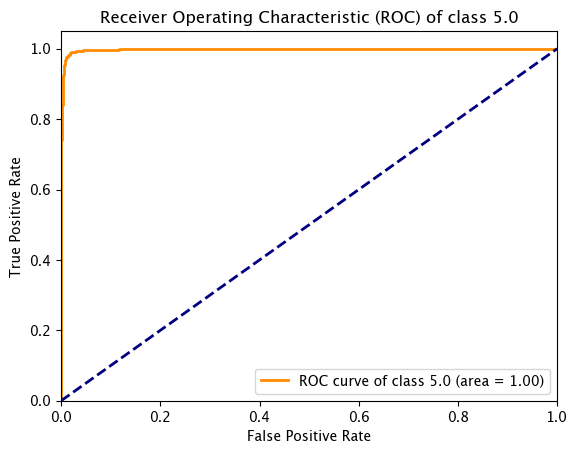

2023-10-20 22:12:23.957273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,23,1,128]
	 [[{{node inputs}}]]
2023-10-20 22:12:24.025293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,23,1,128]
	 [[{{node inputs}}]]


Accuracy: 0.9750088621056363
Confusion Matrix: 
[[ 516   11    0    0    0    0]
 [   3  593    5    0    0    1]
 [   1    5 1377    2    1    0]
 [   0    0    3  516    5    0]
 [   0    2    6    0 1192   71]
 [   0    3    2    0   20 1307]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       527
           1       0.97      0.99      0.98       602
           2       0.99      0.99      0.99      1386
           3       1.00      0.98      0.99       524
           4       0.98      0.94      0.96      1271
           5       0.95      0.98      0.96      1332

    accuracy                           0.98      5642
   macro avg       0.98      0.98      0.98      5642
weighted avg       0.98      0.98      0.97      5642

INFO:tensorflow:Assets written to: /Users/clei/Desktop/项目/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/clei/Desktop/项目/cnn_model/assets


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    # Averaging
    def time_window_averaging(data, window_size):
        averaged_data = []
        for i in range(0, len(data) - window_size + 1, window_size):
            window = data[i:i+window_size]
            averaged_data.append(window.mean(axis=0))
        return pd.DataFrame(averaged_data)

    averaged_data = time_window_averaging(dataset, window_size)
    averaged_data['act'] = averaged_data['act'].round().astype(int)  # Convert 'act' column back to integer after averaging
    
    lb = LabelBinarizer()
    if task == 'multi_class':
        data_with_labels = np.c_[averaged_data.drop(columns=[target]).values, 
                                lb.fit_transform(averaged_data[target]).argmax(axis=1)]
    else:
        data_with_labels = np.c_[averaged_data.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean_with_noise.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)

